# Titanic: Machine Learning from Disaster

In this challenge, I completed the analysis of what sorts of people were likely to survive. In particular, I applied the tools of machine learning to predict which passengers survived the tragedy.

https://www.kaggle.com/c/titanic

Machine learning problems have many more dimensions:
    1. Bugs in implementation
    2. Algorithm design
    3. Model issues
    4. Data quality

Work flow:
    1. Data exploration
    2. Feature engineering
    3. Feature selection
    4. Model selection/tuning

# Data exploration

In [1]:
import pandas as pd
train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Finding Missing Value

In [3]:
pd.isnull(train).any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

Age / Cabin / Embarked have null/missing values. 

In [4]:
train["Embarked"].mode()

0    S
dtype: object

# Refill missing value and Extract feature

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set,
    refill the missing values with mean. 
    """
    #df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    df["Age"] = df["Age"].fillna(-0.5)
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins'/category. 
    """
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    #df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
from sklearn.preprocessing import minmax_scale
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_cabin(df)
    df = process_titles(df)

    columns = ["Pclass","Title","Sex","Age_categories", "Fare_categories", "Cabin_type","Embarked"]
    for c in columns:
        df= create_dummies(df,c)
        
    columns2 = ["SibSp","Parch"]
    for c in columns2:
        df[c+"_scaled"]= minmax_scale(df[c])
        
    return df

train=preprocess(train)
holdout=preprocess(holdout)       

/Users/mia/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [7]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Embarked_C,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,1,0,0,1,0.125,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,1,0,0,0.125,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,1,0,0,1,0.000,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,0,0,1,0.125,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,1,0,0,1,0.000,0.0


In [8]:
train.columns[16:]

Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master', 'Title_Miss',
       'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Sex_female',
       'Sex_male', 'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'SibSp_scaled', 'Parch_scaled'],
      dtype='object')

In [14]:
train_x = train.iloc[:,16:]
holdout_x = holdout.iloc[:,15:]
train_y = train.iloc[:,1]

In [15]:
train_x.head()

,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Sex_female,...,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Embarked_C,Embarked_Q,Embarked_S,SibSp_scaled,Parch_scaled
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0.125,0.0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0.125,0.0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0.000,0.0
3,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0.125,0.0
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0.000,0.0


# Select the best-performing feature

In [19]:
lr = LogisticRegression()
lr.fit(train_x, train_y)
coefficients = lr.coef_

In [20]:
coefficients.shape

(1, 36)

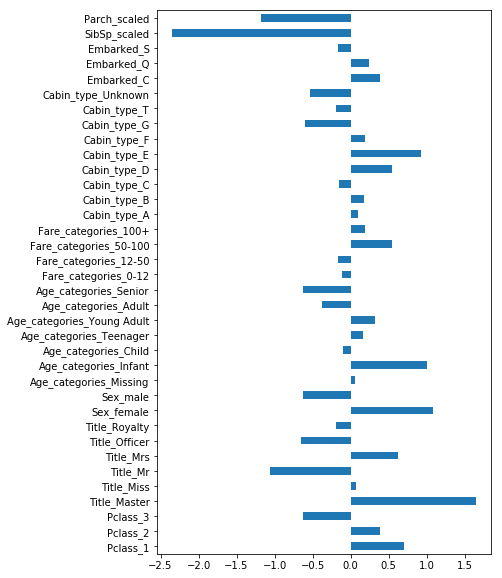

In [21]:
import matplotlib.pyplot as plt
feature_importance = pd.Series(coefficients[0],index=train_x.columns)
feature_importance.plot.barh(figsize=(6, 10))
plt.show()

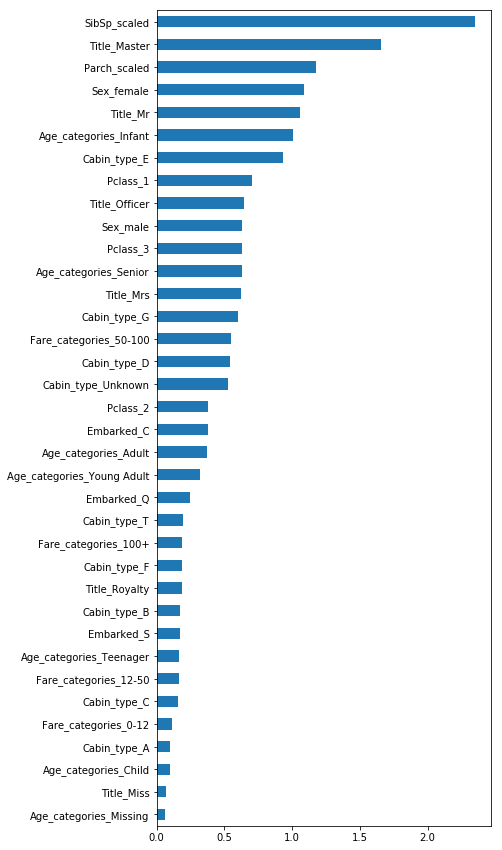

In [22]:
feature_importance_sorted = feature_importance.abs().sort_values()
feature_importance_sorted.plot.barh(figsize=(6, 15))
plt.show()

From this chart above, the best performing features are ['SibSp_scaled','Title_Master', 'Parch_scaled','Sex_female', 'Title_Mr','Age_categories_Infant','Cabin_type_E','Pclass_1', 'Title_officer', 'Sex_male', 'Pclass_3']

In [25]:
from sklearn.model_selection import cross_val_score
columns = ['SibSp_scaled','Title_Master', 'Parch_scaled','Sex_female', 'Title_Mr','Age_categories_Infant','Cabin_type_E',
       'Pclass_1', 'Title_Officer', 'Sex_male', 'Pclass_3']
lr = LogisticRegression()
scores = cross_val_score(lr,train_x[columns],y = train_y,cv=10)
accuracy = scores.mean()

In [26]:
accuracy

0.82165673589830901

In [27]:
train_x=train_x[columns]
holdout_x=holdout_x[columns]

# Selecting Different Models

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import BernoulliNB
import numpy as np

def bestAlpha(X,y,kf):
    k = []
    acc = []
    for K in kf:
        #print(K)
        lr = BernoulliNB(alpha = K) 
        scores = cross_val_score(lr, train_x, train_y, cv = 10)
        accuracy = np.mean(scores)
        acc.append(accuracy)
        k.append(K)
    mac = max(acc)
    maci = acc.index(mac)
    #print(k)
    #print(acc)
    return k[maci]

alphas = np.logspace(-2,10,5) #alpha: Additive smoothing parameter
a = bestAlpha(train_x,train_y,alphas)

print("Naive Bayes classifier")
print("------------------------------")
print("best k:",a)

lr = BernoulliNB(alpha = a)
scores = cross_val_score(lr, train_x, train_y, cv = 10)
accuracy = np.mean(scores)
print("best score:",accuracy)

Naive Bayes classifier
------------------------------
best k: 10.0
best score: 0.794613834979


In [29]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

scores = cross_val_score(lr, train_x, train_y, cv = 10)
accuracy = np.mean(scores)

print("Logistic Regression")
print("------------------------------")
print("best score:",accuracy)


Logistic Regression
------------------------------
best score: 0.821656735898


In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
hyperparameters = {
    "criterion": ["entropy","gini"],
    "max_depth": [5,10],
    "max_features": ["log2","sqrt"],
    "min_samples_leaf": [1, 5],
    "min_samples_split": [3, 5],
    "n_estimators": [6,9]
    
}

lr = RandomForestClassifier()
grid = GridSearchCV(lr,param_grid=hyperparameters,cv=10)
grid.fit(train_x,train_y)
best_params = grid.best_params_
best_score = grid.best_score_

print("Random Forest")
print("------------------------------")
print("best score:",best_score)

Random Forest
------------------------------
best score: 0.833894500561


# Submit predicting values to Kaggle

In [32]:
best_rt = grid.best_estimator_
holdout_predictions = best_rt.predict(holdout_x)

holdout_ids = holdout["PassengerId"]
submission_df = {"PassengerId": holdout_ids,
                 "Survived": holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv("submission.csv",index=False)

In [35]:
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
